In [12]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Masking,BatchNormalization, CuDNNLSTM
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [2]:
data = pd.read_csv('induce-data-2019-08-08.csv')

In [3]:
data.head()

,Unnamed: 0,user,step,createdAt,question,result,topic,ageGroup,uniqueQuestionID,type,feature
0,0,10fee518,0,2019-06-17 09:21:02.736000+00:00,C_E_F_T,correct,cards,11-13,C_E_F_T_INTRO,INTRO,type
1,1,10fee518,1,2019-06-17 09:21:15.081000+00:00,C_E_F_C,correct,cards,11-13,C_E_F_C_INTRO,INTRO,color
2,2,10fee518,2,2019-06-17 09:21:24.037000+00:00,C_E_F_O,correct,cards,11-13,C_E_F_O_INTRO,INTRO,orientation
3,3,10fee518,3,2019-06-17 09:21:33.090000+00:00,A_E_F_T,correct,animals,11-13,A_E_F_T_INTRO,INTRO,type
4,4,10fee518,4,2019-06-17 09:21:42.062000+00:00,A_E_F_O,correct,animals,11-13,A_E_F_O_INTRO,INTRO,orientation


In [7]:
#data_card = data[data.type == 'TRIK']
data_card = data
data_card['question'] = data_card['question'].apply(lambda x : x[-2]+x[-1])
data_card = data_card.drop('createdAt', axis=1)
data_card = data_card.drop('uniqueQuestionID', axis=1)
data_card.head()

,Unnamed: 0,user,step,question,result,topic,ageGroup,type,feature
0,0,10fee518,0,_T,correct,cards,11-13,INTRO,type
1,1,10fee518,1,_C,correct,cards,11-13,INTRO,color
2,2,10fee518,2,_O,correct,cards,11-13,INTRO,orientation
3,3,10fee518,3,_T,correct,animals,11-13,INTRO,type
4,4,10fee518,4,_O,correct,animals,11-13,INTRO,orientation


In [8]:
le = preprocessing.LabelEncoder()
values = data_card.values
for i in range(values.shape[1]):
    values[:,i] = le.fit_transform(values[:,i])
values_user = np.split(values[:, 2:], np.cumsum(np.unique(values[:, 1], return_counts=True)[1])[:-1])

In [9]:
def split_sequence(data):
    X, y = list(), list()
    for u in data:
        for i in range(u.shape[0]-1):
            end_idx = i+1
            start_idx = 0
            X.append(u[start_idx:end_idx, :])
            y.append(u[end_idx, 2])
    return np.array(X), np.array(y)

np.random.shuffle(values_user)
u_train, u_val = values_user[:int(len(values_user)*0.7)], values_user[int(len(values_user)*0.7):]

X_train, y_train = split_sequence(u_train)
X_val, y_val = split_sequence(u_val)

X_train = pad_sequences(X_train, value=99)
X_val = pad_sequences(X_val, value=99)
print(X_train[10])

[[99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99

In [46]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import keras
# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()



In [51]:
amsgrad = Adam(amsgrad=False)

model = Sequential()
model.add(Masking(mask_value=99))
model.add(LSTM(units=120, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=120))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(optimizer=amsgrad, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

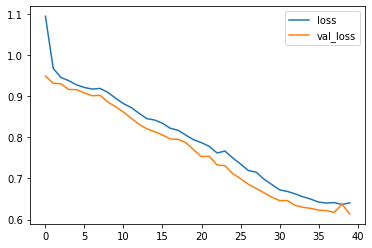

Epoch 41/100
 800/9595 [=>............................] - ETA: 1:05 - loss: 0.6079 - sparse_categorical_accuracy: 0.6813

KeyboardInterrupt: 

In [52]:

history = model.fit(X_train, np.asarray(y_train), epochs=100, batch_size=200, shuffle=True, verbose=1, validation_data=(X_val, y_val), callbacks=[plot_losses])
model.summary()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

## Bayesian LSTM

In [ ]:
amsgrad = Adam(amsgrad=False)
dropout=0.15

model = Sequential()
model.add(Masking(mask_value=99))
model.add(LSTM(units=30, recurrent_dropout=dropout, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout))
model.add(LSTM(units=30))
model.add(Dropout(dropout))
model.add(Activation('relu'))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(optimizer=amsgrad, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])



In [ ]:
history = model.fit(X_train, np.asarray(y_train), epochs=100, batch_size=200, shuffle=True, verbose=1, validation_data=(X_val, y_val), callbacks=[plot_losses])
model.summary()

In [23]:
def split_sequence_test(data):
    X, y = list(), list()
    for u in data:
        for i in range(5, u.shape[0]-1):
            end_idx = i+1
            start_idx = 0
            X.append(u[start_idx:end_idx, :])
            y.append(u[end_idx, 2])
    return np.array(X), np.array(y)
X_test, y_test = split_sequence_test(u_val)

X_test = pad_sequences(X_test, value=99)
print(X_test[0])

[[99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [99 99 99 99 99 99 99]
 [ 0  1  2  0  1  0  0]
 [ 1  2  2  0  1  0  0]
 [ 2  0  1  0  1  0  0]
 [ 3  0  0  1  1  0  0]
 [ 4  1  2  1  1  0  0]
 [ 5  2  1  1  1  0  0]]


In [24]:
scores = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

804/804 [==============================] - 3s 4ms/step
Accuracy: 57.09%
